In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev
import time

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import streaming_classifier, zeroes_classifier


In [2]:

waves, labels, samprate = load_training_data(path = "/Users/darap/Documents/School/University/2021, Sem. 1/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow", "left-right-middle-sandeep", "left-right-middle-marina"])


c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\Classifier\load_data.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)
dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'right-middle']) dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'right-middle'])


In [4]:
# ASSUMES THAT HEIGHT_THRESHOLD AND CONSECUTIVE_SAMPLES_THRESHOLD ARE INDEPENDENT

# Set parameters such that event detection window lands in the middle of the signal

hyp_event_smart_threshold_window = 5
hyp_event_smart_threshold_factor = 5

hyp_detection_buffer_end = 0.6
hyp_detection_buffer_start = 0.2


det_window = 0.6432

window_size = det_window + hyp_detection_buffer_end + hyp_detection_buffer_start

N_loops_over_window = 15

buffer_size = window_size/N_loops_over_window

hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))
#print(hyp_consecutive_triggers)




# fig, ax = plt.subplots(len(waves), 1)
# fig.set_size_inches(15, 3*len(waves))



all_accuracies = {}

#CONSEC OPTIMISATION
for i in range(5, 100, 5):
    current_accuracies = []
    consec_threshold = round(i / 100, 2)
    print(consec_threshold)
    for i, key in enumerate(waves):
        predictions, predictions_timestamps, predictions_storage = streaming_classifier(
            waves[key], # Either the array from file (or ser if live = True)
            samprate,
            classifier = zeroes_classifier, 
            using_zeroes_classifier = True,
            zeroes_height_threshold = 10,
            zeroes_consec_threshold = consec_threshold,
            window_size = window_size, # Total detection window [s]
            N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
            hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off end of the window in order to define the middle portion
            hyp_detection_buffer_start = hyp_detection_buffer_start, # seconds - how much time to shave off start of the window in order to define the middle portion
            hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, # The length of the calibration period to define the threshold
            hyp_calibration_statistic_function = np.std, # Function that calculates the calibration statistic
            hyp_test_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the test statistic
            hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, # The scale factor of the calibration range that will become the threshold
            hyp_event_history = hyp_consecutive_triggers+1, # How many historical event detection results are kept in memory (whether the test criteria failed or passed)
            hyp_consecutive_triggers = hyp_consecutive_triggers, # How many threshold triggers need to occur in a row for an event to be called
            hyp_consecutive_reset = 1, # How many threshold failures need to occur in a row for the classifier to be primed for a new event
            total_time = None,  # max time. If none, it goes forever!
            plot = False, # Whether to plot the livestream data
            store_events = True, # Whether to return the classification window array for debugging purposes
            store_times = False, # To see how long classification takes
            verbose = False, # lol
            live = False, # Whether we're live
            hyp_timeout = 10,
            timeout = False)

        actuals = "".join(labels[key].label)

        lev_dist = lev(actuals, predictions)
        acc = abs(len(actuals) - lev_dist)/len(actuals)
        current_accuracies.append(acc)
    all_accuracies[consec_threshold] = np.mean(current_accuracies)
print("done")

#print(all_accuracies)


0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
done


Text(0.5, 1.0, 'Classifier Accuracy vs. Consecutive Seconds without Zero-Crossings')

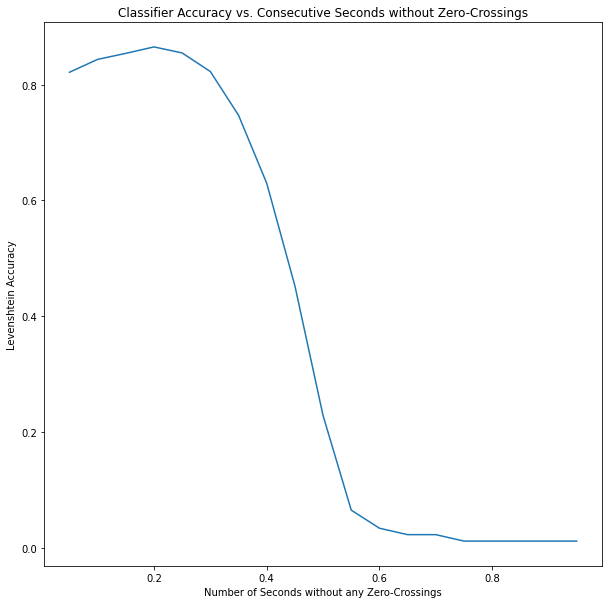

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(all_accuracies.keys(), all_accuracies.values())
plt.ylabel("Levenshtein Accuracy")
plt.xlabel("Number of Seconds without any Zero-Crossings")
plt.title("Classifier Accuracy vs. Consecutive Seconds without Zero-Crossings")

In [7]:
best_consecs = []
best_value = 0
for value in all_accuracies.values():
    if round(value, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
        best_value = value

for key, value in all_accuracies.items():
    if round(value, 5) == round(best_value, 5):
        best_consecs.append(key)

print("Best consec threshold values:", best_consecs)
print("Accuracy with best consec threshold:", all_accuracies[best_consecs[0]])

Best consec threshold values: [0.2]
Accuracy with best consec threshold: 0.8649380122419338
